In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cp -r /content/drive/MyDrive/CS736_MIC_Project/ /content/

In [ ]:
!unzip /content/drive/MyDrive/CS736_MIC_Project/kaggle_3m.zip -d /content/

In [7]:
import os
import glob
import random
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image
from typing import Callable
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms


In [8]:
file_paths = glob.glob("/content/kaggle_3m/*/*.tif")
img_paths = [x for x in file_paths if 'mask' not in x]
mask_paths = []
for path in img_paths:
    m_path = path[:-4]+'_mask.tif'
    mask_paths.append(m_path)

print("Total Images:", len(img_paths))

Total Images: 3929


In [9]:
class MRIDataSet(Dataset):
    def __init__(self, image_path_list, mask_path_list, train=True)-> None:

        super(MRIDataSet).__init__()

        temp = list(zip(image_path_list, mask_path_list))
        random.shuffle(temp)
        image_path_list, mask_path_list = zip(*temp)
        image_path_list, mask_path_list = list(image_path_list), list(mask_path_list)

        if train==True:
            image_names = image_path_list[:int(0.7*len(image_path_list))]     # 70% training data
            mask_names = mask_path_list[:int(0.7*len(image_path_list))]       # 30% val data
        else:
            image_names = image_path_list[int(0.7*len(image_path_list)):]
            mask_names = mask_path_list[int(0.7*len(image_path_list)):]

        self.image_names = image_names
        self.mask_names = mask_names

    def __getitem__(self, index)-> (torch.Tensor, torch.Tensor):

        image = imread(self.image_names[index]) 
        image = image.astype(np.float64)
        mask = np.clip(imread(self.mask_names[index]), 0, 1)
        true_image = image
        true_image = np.moveaxis(image, -1, 0)
        
        low = np.percentile(image, 10, axis=(0, 1, 2))
        high = np.percentile(image, 99, axis=(0, 1, 2))
        image = (image - low) / (high - low)

        image = np.moveaxis(image, -1, 0)

        image = torch.Tensor(image)
        mask = torch.Tensor(mask)
        true_image = torch.Tensor(true_image)
        mask = mask[np.newaxis,...]

        return image,mask,true_image

    def __len__(self):
        return len(self.image_names)

In [10]:
class UNetBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int) -> None:

        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class UNet(nn.Module):

    def __init__(self, in_channels: int = 3, out_channels: int = 1, 
                    n_features: int = 32, depth: int = 5) -> None:

        super(UNet, self).__init__()

        self.layers = []
        self.activations = []
        
        self.layers.append(UNetBlock(in_channels, n_features))
        self.layers[-1].register_forward_hook(self.push_activation())
        self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        for _ in range(depth-2):
            self.layers.append(UNetBlock(n_features, n_features))
            self.layers[-1].register_forward_hook(self.push_activation())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layers.append(UNetBlock(n_features, n_features))
        
        for _ in range(depth-1):
            self.layers.append(nn.ConvTranspose2d(
                n_features, n_features, kernel_size=2, stride=2, bias=False
            ))
            self.layers[-1].register_forward_hook(self.pop_activation())
            self.layers.append(UNetBlock(n_features*2, n_features))
            
        self.layers.append(nn.Conv2d(
            in_channels=n_features, out_channels=out_channels, kernel_size=1
        ))
        
        self.layers = nn.Sequential(*self.layers)
    
    def push_activation(self) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], None]:

        def hook(module, input, output):
            self.activations.append(output)
        return hook
    
    def pop_activation(self) -> Callable[[torch.nn.Module, torch.Tensor, torch.Tensor], torch.Tensor]:

        def hook(module, input, output):
            return torch.cat(
                (output, self.activations.pop()),
                dim=1
            )
        return hook

    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class DiceLoss(nn.Module):

    def __init__(self) -> None:

        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred : torch.Tensor, y_true : torch.Tensor) -> torch.Tensor:

        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = MRIDataSet(img_paths,mask_paths,train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

val_dataset = MRIDataSet(img_paths,mask_paths,train=False)
val_loader = DataLoader(val_dataset,batch_size = 1,shuffle = False)

model = UNet(in_channels=3, out_channels=1, depth=4)
model.cuda()

criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30,], gamma=0.1)

n_epochs = 150

In [ ]:
train_losses = []
val_losses = []

best_loss = 1

for epoch in range(n_epochs):
    model.train()

    train_loss = 0
    for x, y_true in tqdm(train_loader):
        x, y_true = x.cuda(), y_true.cuda()

        optimizer.zero_grad()

        y_pred = model(x)
        loss = criterion(y_pred, y_true)

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    scheduler.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y_true in val_loader:
            x, y_true = x.to(device=device, dtype=torch.float), y_true.cuda()
            y_pred = model(x)
            loss = criterion(y_pred, y_true)
            val_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print("Epoch:{}".format(epoch))
    print("Train_loss:{},  Val_loss:{}".format(train_loss,val_loss))
    
    if (val_loss <= best_loss):
        best_loss = val_loss
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss
            }, 
            '/content/drive/MyDrive/CS736_MIC_Project/model_depth4.pt'
        )

100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:0
Train_loss:0.955614601630111,  Val_loss:0.9439762452164212


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:1
Train_loss:0.9385626369784045,  Val_loss:0.9277517557949633


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:2
Train_loss:0.914752071333486,  Val_loss:0.8941845849559114


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:3
Train_loss:0.8735351586757705,  Val_loss:0.834241378951717


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:4
Train_loss:0.798917954397756,  Val_loss:0.758127240313066


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:5
Train_loss:0.6850598537644674,  Val_loss:0.6152507288230432


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:6
Train_loss:0.5619424212464067,  Val_loss:0.468338574912097


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:7
Train_loss:0.4545983211245648,  Val_loss:0.4524782042245607


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:8
Train_loss:0.3841536762409432,  Val_loss:0.32305979285691233


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:9
Train_loss:0.3111380612434343,  Val_loss:0.30157614157006546


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:10
Train_loss:0.30366903508818427,  Val_loss:0.25714904674001643


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:11
Train_loss:0.2895741091911183,  Val_loss:0.24898504445681702


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:12
Train_loss:0.25626077260388885,  Val_loss:0.22378727149319005


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:13
Train_loss:0.24189861101466556,  Val_loss:0.20980348699801676


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:14
Train_loss:0.22471304064573244,  Val_loss:0.24896905551085602


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:15
Train_loss:0.23104972790840062,  Val_loss:0.21364106962809692


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:16
Train_loss:0.22075835251530937,  Val_loss:0.18485180187869715


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:17
Train_loss:0.20722940824059552,  Val_loss:0.19043348769883853


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:18
Train_loss:0.2101509394340737,  Val_loss:0.21367644015196208


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:19
Train_loss:0.20680489200492239,  Val_loss:0.20832732078191396


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:20
Train_loss:0.2053201113675916,  Val_loss:0.17755038673813278


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:21
Train_loss:0.19628214091062546,  Val_loss:0.16820385125843254


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:22
Train_loss:0.1987269740811614,  Val_loss:0.16891069629707853


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:23
Train_loss:0.19970473837713862,  Val_loss:0.16572691379366694


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:24
Train_loss:0.19208753472843834,  Val_loss:0.158144492555309


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:25
Train_loss:0.18761054305143135,  Val_loss:0.15922416102241826


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:26
Train_loss:0.19316649748835452,  Val_loss:0.17537621831571734


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:27
Train_loss:0.19241900343534557,  Val_loss:0.16230748875721082


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:28
Train_loss:0.1746340215552685,  Val_loss:0.1570758235615653


100%|██████████| 344/344 [01:50<00:00,  3.10it/s]


Epoch:29
Train_loss:0.21067599380432173,  Val_loss:0.18951292013799823


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:30
Train_loss:0.1722915779019511,  Val_loss:0.1699392715015927


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:31
Train_loss:0.1830562734326651,  Val_loss:0.15846888559895592


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:32
Train_loss:0.16651306093432183,  Val_loss:0.1575141130266963


100%|██████████| 344/344 [01:50<00:00,  3.11it/s]


Epoch:33
Train_loss:0.18386589579804,  Val_loss:0.15318746824522275


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:34
Train_loss:0.17151030534228615,  Val_loss:0.15447230757893743


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:35
Train_loss:0.1635295455885488,  Val_loss:0.15020212732456825


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:36
Train_loss:0.1707459885713666,  Val_loss:0.15875206847448606


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:37
Train_loss:0.1602347420398579,  Val_loss:0.14970075923043327


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:38
Train_loss:0.15090334571378175,  Val_loss:0.1480998634486585


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:39
Train_loss:0.1553173591924268,  Val_loss:0.14713060936412295


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:40
Train_loss:0.16871123778265576,  Val_loss:0.14450365184126673


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:41
Train_loss:0.1562554844936659,  Val_loss:0.14453197331041903


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:42
Train_loss:0.14449024945497513,  Val_loss:0.14293304730106043


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:43
Train_loss:0.15007318296404773,  Val_loss:0.14208601294337092


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:44
Train_loss:0.15760376408349636,  Val_loss:0.14146148473829837


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:45
Train_loss:0.16445278705552566,  Val_loss:0.13659095321152662


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:46
Train_loss:0.15222804976064105,  Val_loss:0.14081656530096726


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:47
Train_loss:0.16698439783135124,  Val_loss:0.13760492809720942


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:48
Train_loss:0.16037196700656137,  Val_loss:0.15322446903666934


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:49
Train_loss:0.1403281404528507,  Val_loss:0.13638786246647705


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:50
Train_loss:0.1536601686546969,  Val_loss:0.13469830960840792


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:51
Train_loss:0.1568679792243381,  Val_loss:0.13657660580970146


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:52
Train_loss:0.14241962290780488,  Val_loss:0.1332250471050675


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:53
Train_loss:0.1368931947752487,  Val_loss:0.1378239131457097


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:54
Train_loss:0.15158318780189337,  Val_loss:0.1352360534506875


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:55
Train_loss:0.13493616653736248,  Val_loss:0.13488781210538503


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:56
Train_loss:0.14163539333398953,  Val_loss:0.13757582854580236


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:57
Train_loss:0.14765657397896745,  Val_loss:0.13285057850786158


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:58
Train_loss:0.1516785808773928,  Val_loss:0.13398129714501872


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:59
Train_loss:0.14411230281341908,  Val_loss:0.13279749533614596


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:60
Train_loss:0.14103952084862909,  Val_loss:0.13335876529281204


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:61
Train_loss:0.13550478254639825,  Val_loss:0.13139011006097537


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:62
Train_loss:0.14598582511724428,  Val_loss:0.13155915930464462


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:63
Train_loss:0.13855107544466508,  Val_loss:0.13020211740120038


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:64
Train_loss:0.14433818449114644,  Val_loss:0.1288550802179285


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:65
Train_loss:0.14265535789173703,  Val_loss:0.12883464106031367


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:66
Train_loss:0.1430116827751315,  Val_loss:0.12750405274532936


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:67
Train_loss:0.1436290730570638,  Val_loss:0.12859336790200826


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:68
Train_loss:0.14860031511201416,  Val_loss:0.12740647349808668


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:69
Train_loss:0.1404000661054323,  Val_loss:0.12558104903311343


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:70
Train_loss:0.14525214963874153,  Val_loss:0.13129062427056803


100%|██████████| 344/344 [01:49<00:00,  3.16it/s]


Epoch:71
Train_loss:0.145793815684873,  Val_loss:0.12651927769184113


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:72
Train_loss:0.14012676321489867,  Val_loss:0.12538560379195857


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:73
Train_loss:0.13491075815156447,  Val_loss:0.12572630837156967


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:74
Train_loss:0.1453104577092237,  Val_loss:0.12893358879798167


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:75
Train_loss:0.13465381413698196,  Val_loss:0.12749781439433228


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:76
Train_loss:0.14292504829029704,  Val_loss:0.12442073306521854


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:77
Train_loss:0.14649782728317173,  Val_loss:0.12543256661376437


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:78
Train_loss:0.14663038576065107,  Val_loss:0.1307203854257996


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:79
Train_loss:0.14654376583043918,  Val_loss:0.12600842641817556


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:80
Train_loss:0.1395854513312495,  Val_loss:0.12259990137976569


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:81
Train_loss:0.13534154119186623,  Val_loss:0.12681240487743067


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:82
Train_loss:0.13637853795012764,  Val_loss:0.12291448784841073


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:83
Train_loss:0.13477836549282074,  Val_loss:0.12414241481471706


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:84
Train_loss:0.13453280215346536,  Val_loss:0.12433570784491461


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:85
Train_loss:0.12693468204071356,  Val_loss:0.1237154973519815


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:86
Train_loss:0.1290805537340253,  Val_loss:0.12276218750992336


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:87
Train_loss:0.13431950381328894,  Val_loss:0.12499415552293933


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:88
Train_loss:0.14484196416167325,  Val_loss:0.12215102766011213


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:89
Train_loss:0.12841728814812595,  Val_loss:0.12552665254554232


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:90
Train_loss:0.12488485110360523,  Val_loss:0.12701909525974378


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:91
Train_loss:0.13757311639397643,  Val_loss:0.1215794199221843


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:92
Train_loss:0.12783266950485317,  Val_loss:0.12299237339883237


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:93
Train_loss:0.14309409208769022,  Val_loss:0.12083538883441203


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:94
Train_loss:0.12849938332341437,  Val_loss:0.11959883167936995


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:95
Train_loss:0.12547480314970016,  Val_loss:0.11925785042144157


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:96
Train_loss:0.1264498180081678,  Val_loss:0.1237573257169208


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:97
Train_loss:0.1319260931638784,  Val_loss:0.12337540815005431


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:98
Train_loss:0.14147878091695698,  Val_loss:0.12299641805726129


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:99
Train_loss:0.12899606952140497,  Val_loss:0.12140894902719034


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:100
Train_loss:0.132033480634523,  Val_loss:0.11943137404080983


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:101
Train_loss:0.13060114064881967,  Val_loss:0.1188031036306072


100%|██████████| 344/344 [01:49<00:00,  3.16it/s]


Epoch:102
Train_loss:0.1298872620560402,  Val_loss:0.1184351081783707


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:103
Train_loss:0.13375656947840092,  Val_loss:0.12315375982104121


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:104
Train_loss:0.12030288473118184,  Val_loss:0.12073844429608938


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:105
Train_loss:0.1300709405264189,  Val_loss:0.12107880252438623


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:106
Train_loss:0.13798154699941015,  Val_loss:0.11983119958155863


100%|██████████| 344/344 [01:49<00:00,  3.16it/s]


Epoch:107
Train_loss:0.12728059603724368,  Val_loss:0.119963195275616


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:108
Train_loss:0.13690936409456786,  Val_loss:0.1177477091550827


100%|██████████| 344/344 [01:49<00:00,  3.16it/s]


Epoch:109
Train_loss:0.1362304110513177,  Val_loss:0.12109296466853167


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:110
Train_loss:0.13058988819288653,  Val_loss:0.11988484778919735


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:111
Train_loss:0.13801128018734066,  Val_loss:0.11675147349770004


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:112
Train_loss:0.1329686075102451,  Val_loss:0.11832253514109431


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:113
Train_loss:0.1313087196890698,  Val_loss:0.11732684921573948


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:114
Train_loss:0.1432716103140698,  Val_loss:0.12213328520993928


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:115
Train_loss:0.1267197307112605,  Val_loss:0.1176776684619285


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:116
Train_loss:0.13346477892509725,  Val_loss:0.11999917151154699


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:117
Train_loss:0.12058532688506814,  Val_loss:0.11908758733723615


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:118
Train_loss:0.12371921175441077,  Val_loss:0.11663463792285404


100%|██████████| 344/344 [01:48<00:00,  3.16it/s]


Epoch:119
Train_loss:0.13370214610598807,  Val_loss:0.11978292062475875


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:120
Train_loss:0.1319741861418236,  Val_loss:0.11845253367681761


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:121
Train_loss:0.1229773953903553,  Val_loss:0.11709677609237465


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:122
Train_loss:0.12022534082102221,  Val_loss:0.11641080758056126


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:123
Train_loss:0.12563538534003635,  Val_loss:0.1159848909120302


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:124
Train_loss:0.12607389861761137,  Val_loss:0.11495079140405397


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:125
Train_loss:0.12090190222790075,  Val_loss:0.1149495421229182


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:126
Train_loss:0.12336078892613567,  Val_loss:0.11521845049149282


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:127
Train_loss:0.12198235804951468,  Val_loss:0.11486878387025885


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:128
Train_loss:0.12180076990016671,  Val_loss:0.11562417125379718


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:129
Train_loss:0.1282802035295686,  Val_loss:0.11741721589823027


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:130
Train_loss:0.12059086561203003,  Val_loss:0.11488324242669183


100%|██████████| 344/344 [01:49<00:00,  3.15it/s]


Epoch:131
Train_loss:0.12466594195643137,  Val_loss:0.11474169065823427


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:132
Train_loss:0.12155533651279848,  Val_loss:0.11456689842649408


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:133
Train_loss:0.12673528059277422,  Val_loss:0.11731732294366166


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:134
Train_loss:0.1300412160019542,  Val_loss:0.13867711497319712


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:135
Train_loss:0.13207129822220914,  Val_loss:0.11355251879305453


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:136
Train_loss:0.1277608923440756,  Val_loss:0.11529716124405733


100%|██████████| 344/344 [01:50<00:00,  3.13it/s]


Epoch:137
Train_loss:0.12313373993302501,  Val_loss:0.11292183077013171


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:138
Train_loss:0.1190596196887105,  Val_loss:0.11501032234849157


100%|██████████| 344/344 [01:50<00:00,  3.13it/s]


Epoch:139
Train_loss:0.12494892280462176,  Val_loss:0.11302215223376816


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:140
Train_loss:0.13408358533715092,  Val_loss:0.11505302545186635


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:141
Train_loss:0.12762409916450812,  Val_loss:0.11293030389257379


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:142
Train_loss:0.13723251050294832,  Val_loss:0.11425733969018266


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:143
Train_loss:0.12921524567659512,  Val_loss:0.11387290946535163


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:144
Train_loss:0.12010000559479692,  Val_loss:0.11669775118698945


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:145
Train_loss:0.11851658325555713,  Val_loss:0.11264615566343875


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:146
Train_loss:0.12965612408033636,  Val_loss:0.11225352053706711


100%|██████████| 344/344 [01:49<00:00,  3.14it/s]


Epoch:147
Train_loss:0.11453119855980541,  Val_loss:0.11187354012115582


100%|██████████| 344/344 [01:49<00:00,  3.13it/s]


Epoch:148
Train_loss:0.1222125518807145,  Val_loss:0.1127094473387744


100%|██████████| 344/344 [01:50<00:00,  3.12it/s]


Epoch:149
Train_loss:0.11571741797203242,  Val_loss:0.11168750194278923


In [18]:
ckpt = torch.load('/content/drive/MyDrive/CS736_MIC_Project/model_depth4.pt')

In [14]:
import pandas as pd
import plotly.express as px
df = pd.read_csv("/content/drive/MyDrive/CS736_MIC_Project/trainlosses.csv")
fig = px.line(df, x= 'epoch',y= 'loss', title='Train Loss Curve')
fig.show()


In [15]:
df = pd.read_csv("/content/drive/MyDrive/CS736_MIC_Project/vallosses.csv")
fig = px.line(df, x= 'epoch',y= 'loss', title='Validation Loss Curve')
fig.show()

In [95]:
model.load_state_dict(ckpt['state_dict'])
model.eval()

true_counts = 0
pred_counts = 0

for i in tqdm(range(len(val_dataset))):
    with torch.no_grad():
        x, y_true,_ = val_dataset[i]
        y_true = y_true.numpy().squeeze()
        x = x.reshape(1,3,256,256)
        x = x.cuda()
        y_pred = model(x)
        y_pred = y_pred[0].cpu().numpy().squeeze()
        y_pred = (y_pred > 0.5)
        if np.sum(y_true)==0:                       ## Calculation of Accuracy of classification of model
            true_counts += 1
            if np.sum(y_pred)==0:
                pred_counts +=1
        else:
            true_counts += 1
            if np.sum(y_pred)>0:
                pred_counts += 1

print("\n Classification Accuracy of validation data = {}".format((pred_counts/true_counts)*100))


100%|██████████| 1179/1179 [00:12<00:00, 94.48it/s]


 Classification Accuracy of validation data = 96.77692960135708


In [96]:
model.eval()

true_counts = 0
pred_counts = 0

for i in tqdm(range(len(train_dataset))):
    with torch.no_grad():
        x, y_true,_ = train_dataset[i]
        y_true = y_true.numpy().squeeze()
        x = x.reshape(1,3,256,256)
        x = x.cuda()
        y_pred = model(x)
        y_pred = y_pred[0].cpu().numpy().squeeze()
        y_pred = (y_pred > 0.5)
        if np.sum(y_true)==0:                       ## Calculation of Accuracy of classification of model
            true_counts += 1
            if np.sum(y_pred)==0:
                pred_counts +=1
        else:
            true_counts += 1
            if np.sum(y_pred)>0:
                pred_counts += 1

print("\n Classification Accuracy of training data = {}".format((pred_counts/true_counts)*100))


100%|██████████| 2750/2750 [00:29<00:00, 94.78it/s]


 Classification Accuracy of training data = 97.70909090909092


In [ ]:
val_loader = DataLoader(val_dataset,batch_size = 8,shuffle = False)

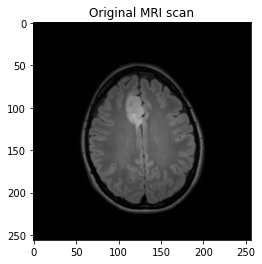

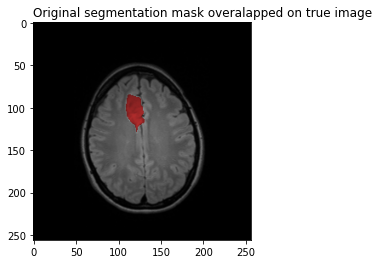

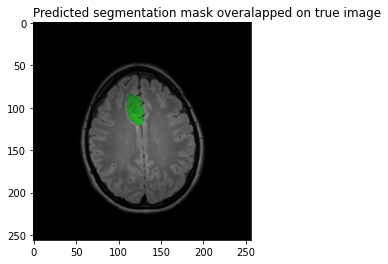

In [97]:
model.eval()
x, y_true,true_image = next(iter(val_loader))
idx = 7

with torch.no_grad():
    x, y_true,true_image  = x.cuda(), y_true.cuda(), true_image.cuda()
    y_pred = model(x)
    true_image_1 = true_image[idx]
    y_pred = y_pred.cpu().numpy().squeeze()

y_pred = (y_pred > 0.5)
y_true = y_true.cpu().numpy().squeeze()

true_image_1 = true_image_1.cpu().numpy().squeeze()/255.0
true_image_1 = np.moveaxis(true_image_1,0,-1)

plt.figure
plt.imshow(true_image_1)
plt.title("Original MRI scan")
plt.show()

img_true = true_image_1.copy()
img_true[:,:,1][y_true[idx] == 1] /= 4
img_true[:,:,2][y_true[idx] == 1] /= 4
plt.title("Original segmentation mask overalapped on true image",loc='left')
plt.figure
plt.imshow(img_true)
plt.show()

img_pred = true_image_1.copy()
img_pred[:,:,2][y_pred[idx]==1] /= 4
img_pred[:,:,0][y_pred[idx]==1] /= 4
plt.figure
plt.title("Predicted segmentation mask overalapped on true image",loc='left')
plt.imshow(img_pred)
plt.show()
